In [235]:
import os
import numpy as np

folder_path = r"C:\Users\Lorenzo\Desktop\sleep_stages_09_12\clinical_annotations"

groups = {
    "CTL": ["PD009", "PD010", "PD020", "PD022", "PD025", "PD033", "PD043"],
    "DNV": ["PD005", "PD013", "PD027", "PD031", "PD041"],
    "ADV": ["PD002", "PD003", "PD007", "PD008", "PD021", "PD028", "PD036", "PD042"],
    "DYS": ["PD012", "PD014", "PD016", "PD017", "PD029", "PD030", "PD035", "PD038", "PD044", "PD045"],
}

subject_to_group = {subj: group for group, subjects in groups.items() for subj in subjects}

all_data = []

for filename in os.listdir(folder_path):
    if filename.endswith('_stages.npy'):
        # Estrai l'ID del soggetto rimuovendo 'EEG' se presente
        subject_part = filename.replace('_stages.npy', '')
        subject_id = subject_part.replace('EEG', '')  # es: 'PD003EEG' -> 'PD003'

        if subject_id in subject_to_group:
            group = subject_to_group[subject_id]
            full_path = os.path.join(folder_path, filename)
            scoring = np.load(full_path)
            all_data.append((subject_id, group, scoring))
            print(f"✅ {subject_id} ({group}) - scoring: {len(scoring)}")
        else:
            print(f"⚠️ {subject_id} non è in nessun gruppo definito.")

print(f"\nTotale soggetti caricati: {len(all_data)}")


✅ PD002 (ADV) - scoring: 869
✅ PD003 (ADV) - scoring: 1094
✅ PD005 (DNV) - scoring: 883
✅ PD007 (ADV) - scoring: 1173
✅ PD008 (ADV) - scoring: 1038
✅ PD009 (CTL) - scoring: 1000
✅ PD010 (CTL) - scoring: 837
✅ PD012 (DYS) - scoring: 871
✅ PD013 (DNV) - scoring: 971
✅ PD014 (DYS) - scoring: 967
✅ PD016 (DYS) - scoring: 958
✅ PD017 (DYS) - scoring: 1053
✅ PD020 (CTL) - scoring: 897
✅ PD021 (ADV) - scoring: 783
✅ PD022 (CTL) - scoring: 894
✅ PD025 (CTL) - scoring: 670
✅ PD027 (DNV) - scoring: 1029
✅ PD028 (ADV) - scoring: 952
✅ PD029 (DYS) - scoring: 977
✅ PD030 (DYS) - scoring: 832
✅ PD031 (DNV) - scoring: 877
✅ PD033 (CTL) - scoring: 896
✅ PD035 (DYS) - scoring: 998
✅ PD036 (ADV) - scoring: 1027
✅ PD038 (DYS) - scoring: 968
✅ PD041 (DNV) - scoring: 910
✅ PD042 (ADV) - scoring: 998
✅ PD043 (CTL) - scoring: 912
✅ PD044 (DYS) - scoring: 1030
✅ PD045 (DYS) - scoring: 759

Totale soggetti caricati: 30


In [236]:
import pandas as pd
import numpy as np

# Definizione delle fasi
sleep_values = [1, 2, 3, 5]  # N1, N2, N3, REM
scoring_data = []

for subject_id, group, scoring in all_data:
    scoring = scoring.astype(int)
    total_epochs = len(scoring)
    total_minutes = total_epochs * 0.5

    tst_epochs = np.isin(scoring, sleep_values).sum()
    tst_minutes = tst_epochs * 0.5

    se = tst_minutes / total_minutes * 100

    # Sleep Latency
    sleep_found = np.isin(scoring, sleep_values)
    if np.any(sleep_found):
        sl_epochs = np.argmax(sleep_found)
        sl_minutes = sl_epochs * 0.5
    else:
        sl_minutes = np.nan

    # SWS (N3)
    sws_minutes = (scoring == 3).sum() * 0.5

    # WASO
    if np.any(sleep_found):
        sleep_onset_idx = np.argmax(sleep_found)
        waso_epochs = np.sum(scoring[sleep_onset_idx+1:] == 0)
        waso_minutes = waso_epochs * 0.5
    else:
        waso_minutes = np.nan

    # WAKE (percentuale di epoche in cui si è svegli)
    wake_epochs = (scoring == 0).sum()  # Epoche di sveglio (0)
    wake_percent = wake_epochs / total_epochs * 100

    # REM (percentuale di epoche in fase REM)
    rem_epochs = (scoring == 5).sum()  # Epoche in REM (5)
    rem_percent = rem_epochs / total_epochs * 100

    # Percentuale N1, N2, N3
    n1_percent = (scoring == 1).sum() / total_epochs * 100
    n2_percent = (scoring == 2).sum() / total_epochs * 100
    n3_percent = (scoring == 3).sum() / total_epochs * 100

    scoring_data.append({
        "Subject": subject_id,
        "Group": group,        
        "TST (min)": tst_minutes,
        "SE (%)": se,
        "SL (min)": sl_minutes,
        "WASO (min)": waso_minutes,
        "SWS (min)": sws_minutes,        
        "WAKE (%)": wake_percent,
        "N1 (%)": n1_percent,
        "N2 (%)": n2_percent,
        "N3 (%)": n3_percent,
        "REM (%)": rem_percent  # REM dopo N3
    })

# Creazione del DataFrame
df = pd.DataFrame(scoring_data)

# Seleziona solo le colonne numeriche, ordinate correttamente
metrics_cols = [
    "TST (min)", "SE (%)", "SL (min)", "WASO (min)", 
    "SWS (min)", "WAKE (%)", "N1 (%)", "N2 (%)", "N3 (%)", "REM (%)"
]

# Calcolo media e std per gruppo
group_stats = df.groupby("Group")[metrics_cols].agg(['mean', 'std'])

# Trasposizione per avere gruppi sulle colonne
group_stats_T = group_stats.T

# Ordina le colonne come richiesto
ordered_groups = ["CTL", "DNV", "ADV", "DYS"]
group_stats_T = group_stats_T[ordered_groups]

# Visualizzazione finale (con valori arrotondati a 2 decimali)
group_stats_T.round(2)


Group               CTL     DNV     ADV     DYS
TST (min)  mean  303.00  349.50  329.38  296.55
           std    65.59   24.26   49.19   88.65
SE (%)     mean   70.40   75.13   66.58   62.40
           std    17.65    7.36    8.26   15.12
SL (min)   mean   32.86   29.90   28.06   13.00
           std    38.41   18.94   25.16   11.88
WASO (min) mean   99.43   84.50  133.00  154.85
           std    76.38   32.52   47.88   65.34
SWS (min)  mean   50.86   80.10   64.56   59.10
           std    13.10   60.34   46.26   50.68
WAKE (%)   mean   29.40   24.23   32.11   36.31
           std    17.56    7.08    7.81   15.36
N1 (%)     mean    9.60    8.29    9.07    9.77
           std     3.68    5.46    6.56    2.58
N2 (%)     mean   38.20   31.31   30.49   33.16
           std    10.77    9.81    5.09    9.15
N3 (%)     mean   11.64   16.78   13.32   12.07
           std     2.54   11.53    9.82    9.80
REM (%)    mean   10.96   18.75   13.70    7.39
           std     7.28    6.20    7.25    6.30

In [237]:
from scipy.stats import shapiro, levene, bartlett, fligner, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

def compute_statistical_summary(df, metrics_cols):
    summary = []

    for feature in metrics_cols:
        values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

        # ✅ Test di normalità con Shapiro-Wilk
        group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan  # evita errori con gruppi piccolissimi
                           for g, data in zip(ordered_groups, values_by_group)}
        all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

        if all_normal:
            levene_p = levene(*values_by_group)[1]
            bartlett_p = bartlett(*values_by_group)[1]
            var_test = "Levene" if levene_p < 0.05 else "Bartlett"
            var_p = levene_p if levene_p < 0.05 else bartlett_p
        else:
            var_p = fligner(*values_by_group)[1]
            var_test = "Fligner-Killeen"

        if all_normal:
            if var_p > 0.05:
                stat, p = f_oneway(*values_by_group)
                test_used = "One-Way ANOVA"
            else:
                stat, p = f_oneway(*values_by_group)
                test_used = "Welch's ANOVA"
        else:
            stat, p = kruskal(*values_by_group)
            test_used = "Kruskal-Wallis"

        # Calcolo media e std per ogni gruppo
        means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
        stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

        row = {
            "Feature": feature,
            "Test": test_used,
            "Stat": round(stat, 3),
            "p-value": f"{p:.2e}",
            "Var Test": var_test,
            "Var p": f"{var_p:.2e}",
        }

        # Aggiungi media e std per ogni gruppo
        for g in ordered_groups:
            row[f"{g} Mean"] = means[g]
            row[f"{g} Std"] = stds[g]

        summary.append(row)

    return pd.DataFrame(summary)

stats_summary_df = compute_statistical_summary(df, metrics_cols)

# Mostra il risultato
pd.set_option('display.max_columns', None)
print(stats_summary_df)



      Feature            Test   Stat   p-value         Var Test     Var p  \
0   TST (min)   One-Way ANOVA  0.898  4.55e-01         Bartlett  7.25e-02   
1      SE (%)  Kruskal-Wallis  3.474  3.24e-01  Fligner-Killeen  5.96e-02   
2    SL (min)   Welch's ANOVA  1.116  3.61e-01         Bartlett  2.57e-02   
3  WASO (min)   One-Way ANOVA  2.052  1.31e-01         Bartlett  3.32e-01   
4   SWS (min)   Welch's ANOVA  0.427  7.36e-01         Bartlett  2.07e-02   
5    WAKE (%)  Kruskal-Wallis  3.147  3.70e-01  Fligner-Killeen  4.72e-02   
6      N1 (%)  Kruskal-Wallis  3.043  3.85e-01  Fligner-Killeen  4.22e-01   
7      N2 (%)   One-Way ANOVA  1.082  3.74e-01         Bartlett  3.28e-01   
8      N3 (%)   Welch's ANOVA  0.384  7.65e-01         Bartlett  2.03e-02   
9     REM (%)   One-Way ANOVA  3.400  3.26e-02         Bartlett  9.67e-01   

   CTL Mean  CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  DYS Mean  DYS Std  
0    303.00    65.59    349.50    24.26    329.38    49.19    296.55    

In [238]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, bartlett, fligner, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Funzione per calcolare il riassunto statistico
def compute_statistical_summary(df, metrics_cols):
    summary = []

    for feature in metrics_cols:
        values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

        # ✅ Test di normalità con Shapiro-Wilk
        group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan  # evita errori con gruppi piccolissimi
                           for g, data in zip(ordered_groups, values_by_group)}
        all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

        # Colonna 'Distribution (p-value)'
        if all_normal:
            distribution = f"Normal (p={round(min(group_normality.values()), 3)})"
        else:
            distribution = f"Not Normal (p={round(min(group_normality.values()), 3)})"

        # Test di omogeneità della varianza
        if all_normal:
            levene_p = levene(*values_by_group)[1]
            bartlett_p = bartlett(*values_by_group)[1]
            var_test = "Homogeneous" if levene_p > 0.05 else "Heterogeneous"
            var_p = levene_p if levene_p > 0.05 else bartlett_p
        else:
            var_p = fligner(*values_by_group)[1]
            var_test = "Homogeneous" if var_p > 0.05 else "Heterogeneous"

        # Colonna 'Variance (p-value)'
        variance = f"{var_test} (p={round(var_p, 3)})"

        # Test statistico
        if all_normal and var_p > 0.05:
            stat, p = f_oneway(*values_by_group)
            test_used = "One-Way ANOVA"
        elif all_normal:
            stat, p = f_oneway(*values_by_group)
            test_used = "Welch's ANOVA"
        else:
            stat, p = kruskal(*values_by_group)
            test_used = "Kruskal-Wallis"

        # Calcolo media e std per ogni gruppo
        means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
        stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

        row = {
            "Feature": feature,
            "Distribution (p-value)": distribution,
            "Variance (p-value)": variance,
            "Test": test_used,
            "Stat": round(stat, 3),
            "p-value": f"{p:.2e}"
        }

        # Aggiungi media e std per ogni gruppo
        for g in ordered_groups:
            row[f"{g} Mean"] = means[g]
            row[f"{g} Std"] = stds[g]

        summary.append(row)

    return pd.DataFrame(summary)

# Chiamata alla funzione
stats_summary_df = compute_statistical_summary(df, metrics_cols)

# Mostra il risultato
pd.set_option('display.max_columns', None)
print(stats_summary_df)


      Feature Distribution (p-value)       Variance (p-value)            Test  \
0   TST (min)       Normal (p=0.058)    Homogeneous (p=0.058)   One-Way ANOVA   
1      SE (%)   Not Normal (p=0.042)     Homogeneous (p=0.06)  Kruskal-Wallis   
2    SL (min)       Normal (p=0.076)    Homogeneous (p=0.235)   One-Way ANOVA   
3  WASO (min)       Normal (p=0.234)    Homogeneous (p=0.407)   One-Way ANOVA   
4   SWS (min)        Normal (p=0.12)    Homogeneous (p=0.225)   One-Way ANOVA   
5    WAKE (%)   Not Normal (p=0.031)  Heterogeneous (p=0.047)  Kruskal-Wallis   
6      N1 (%)    Not Normal (p=0.04)    Homogeneous (p=0.422)  Kruskal-Wallis   
7      N2 (%)       Normal (p=0.312)    Homogeneous (p=0.564)   One-Way ANOVA   
8      N3 (%)       Normal (p=0.197)    Homogeneous (p=0.167)   One-Way ANOVA   
9     REM (%)       Normal (p=0.211)    Homogeneous (p=0.998)   One-Way ANOVA   

    Stat   p-value  CTL Mean  CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  \
0  0.898  4.55e-01    303.00 

In [239]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, bartlett, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Funzione per calcolare le statistiche per la variabile REM (%)
def analyze_REM(df, ordered_groups):
    feature = 'REM (%)'
    values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

    # Test di normalità con Shapiro-Wilk
    group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan for g, data in zip(ordered_groups, values_by_group)}
    all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

    # Test di omogeneità della varianza
    if all_normal:
        levene_p = levene(*values_by_group)[1]
        bartlett_p = bartlett(*values_by_group)[1]
        var_test = "Levene" if levene_p < 0.05 else "Bartlett"
        var_p = levene_p if levene_p < 0.05 else bartlett_p
    else:
        var_p = fligner(*values_by_group)[1]
        var_test = "Fligner-Killeen"

    # Test statistico: ANOVA o Kruskal-Wallis
    if all_normal:
        if var_p > 0.05:  # Se la varianza è omogenea, esegui One-Way ANOVA
            stat, p = f_oneway(*values_by_group)
            test_used = "One-Way ANOVA"
        else:  # Se la varianza non è omogenea, esegui Welch's ANOVA
            stat, p = f_oneway(*values_by_group)  # Welch's ANOVA usa f_oneway
            test_used = "Welch's ANOVA"
    else:
        stat, p = kruskal(*values_by_group)
        test_used = "Kruskal-Wallis"

    # Calcolo media e deviazione standard per ogni gruppo
    means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
    stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

    row = {
        "Feature": feature,
        "Test": test_used,
        "Stat": round(stat, 3),
        "p-value": f"{p:.2e}",
        "Var Test": var_test,
        "Var p": f"{var_p:.2e}",
    }

    # Aggiungi media e deviazione standard per ogni gruppo
    for g in ordered_groups:
        row[f"{g} Mean"] = means[g]
        row[f"{g} Std"] = stds[g]

    # Test post-hoc: Tukey HSD (ANOVA) o Dunn con correzione Bonferroni (Kruskal-Wallis)
    post_hoc = None
    if test_used == "One-Way ANOVA" and p < 0.05:  # Solo se l'ANOVA è significativa
        tukey_result = pairwise_tukeyhsd(df[feature], df["Group"], alpha=0.05)
        post_hoc = tukey_result
    elif test_used == "Kruskal-Wallis" and p < 0.05:  # Solo se il Kruskal-Wallis è significativo
        post_hoc = sp.posthoc_dunn(df, val_col=feature, group_col="Group", p_adjust="bonferroni")

    row['PostHoc'] = post_hoc

    return pd.DataFrame([row])

# Esegui la funzione sul tuo DataFrame
ordered_groups = ['CTL', 'DNV', 'ADV', 'DYS']  # Cambia con il nome dei tuoi gruppi effettivi

# Calcola le statistiche per REM (%)
REM_stats_df = analyze_REM(df, ordered_groups)

# Verifica il tipo di test post-hoc e stampa i risultati correttamente
post_hoc = REM_stats_df['PostHoc'][0]  # Prendi il test post-hoc dalla riga del DataFrame
if post_hoc is not None:
    if hasattr(post_hoc, 'summary'):  # Se è un risultato Tukey HSD
        print("\nTest post-hoc (Tukey HSD):\n", post_hoc.summary())
    else:  # Se è un risultato Dunn con correzione Bonferroni
        print("\nTest post-hoc (Dunn con correzione Bonferroni):\n", post_hoc)

# Mostra il risultato delle statistiche
print("\nStatistiche per REM (%):")
print(REM_stats_df)



Test post-hoc (Tukey HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   ADV    CTL   -2.737 0.8631 -12.3706  6.8966  False
   ADV    DNV   5.0558 0.5668  -5.5557 15.6673  False
   ADV    DYS  -6.3037 0.2294  -15.133  2.5256  False
   CTL    DNV   7.7928 0.2283  -3.1064 18.6919  False
   CTL    DYS  -3.5667 0.7124 -12.7397  5.6063  False
   DNV    DYS -11.3595 0.0248 -21.5547 -1.1642   True
-----------------------------------------------------

Statistiche per REM (%):
   Feature           Test  Stat   p-value  Var Test     Var p  CTL Mean  \
0  REM (%)  One-Way ANOVA   3.4  3.26e-02  Bartlett  9.67e-01     10.96   

   CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  DYS Mean  DYS Std  \
0     7.28     18.75      6.2      13.7     7.25      7.39      6.3   

                                             PostHoc  
0   Multiple Comparison of Means - Tukey HSD, FWE...  


In [240]:
import numpy as np
import os

# Percorso della cartella con i file
path = r"C:\Users\Lorenzo\Desktop\sleep_stages_09_12\clinical_annotations"

# Funzione per caricare i dati
def load_data(path):
    # Lista di tutti i file nella cartella
    files = os.listdir(path)
    
    # Inizializzo i dizionari per stages e arousals
    all_data = []  # Dati delle fasi del sonno
    arousals_data = []  # Dati degli arousals

    # Carico i dati per ciascun paziente
    for file in files:
        if file.endswith("_stages.npy"):  # Stai cercando i file delle fasi del sonno
            subject_id = file.split('_')[0]  # Es. "PD003"
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            stages = np.load(os.path.join(path, file))  # Carica il file delle fasi del sonno
            all_data.append((subject_id, stages))
        
        if file.endswith("_arousals.npy"):  # Stai cercando i file degli arousals
            subject_id = file.split('_')[0]
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            arousals = np.load(os.path.join(path, file))  # Carica il file degli arousals
            arousals_data.append(arousals)

    return all_data, arousals_data

# Carica i dati
all_data, arousals_data = load_data(path)

# Verifica se la lunghezza dei dati è coerente
assert len(all_data) == len(arousals_data), "I dati delle fasi del sonno e degli arousals non corrispondono per ogni paziente!"

# Crea un dizionario per memorizzare le fasi del sonno senza arousals
subject_clean_stages = {}

# Sovrapponi i dati e determina gli arousals per ogni fase del sonno
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    # Trova gli indici degli arousals
    arousals_indices = np.where(arousals == 1)[0]
    arousals_stages = stages[arousals_indices]

    # Rimuovere gli arousals dai dati delle fasi del sonno
    non_arousal_mask = arousals != 1  # Maschera booleana: True dove NON ci sono arousals
    clean_stages = stages[non_arousal_mask]
    clean_arousals = arousals[non_arousal_mask]  # Dovrebbe essere tutto 0

    # Memorizza i clean stages nel dizionario
    subject_clean_stages[subject_id] = clean_stages

    # Stampa i risultati per ogni soggetto
    print(f"Subject: {subject_id}")
    print(f"Original length: {len(stages)}")
    print(f"Arousals removed: {np.sum(arousals)}")
    print(f"Cleaned length: {len(clean_stages)}")
    print(f"Cleaned stages preview: {clean_stages[:10]}")
    print("-" * 40)

for (subject_id, stages), arousals in zip(all_data, arousals_data):
    non_arousal_mask = arousals != 1  # Maschera per escludere gli arousals
    clean_stages = stages[non_arousal_mask]
    subject_clean_stages[subject_id] = clean_stages

# Verifica
print(f"Subjects with clean stages: {list(subject_clean_stages.keys())}")

Subject: PD002
Original length: 869
Arousals removed: 39
Cleaned length: 830
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD003
Original length: 1094
Arousals removed: 96
Cleaned length: 998
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD005
Original length: 883
Arousals removed: 72
Cleaned length: 811
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD007
Original length: 1173
Arousals removed: 178
Cleaned length: 995
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD008
Original length: 1038
Arousals removed: 71
Cleaned length: 967
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD009
Original length: 1000
Arousals removed: 139
Cleaned length: 861
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: P

In [241]:
import numpy as np
import os
import pandas as pd

# Percorso della cartella con i file
path = r"C:\Users\Lorenzo\Desktop\sleep_stages_09_12\clinical_annotations"

# Funzione per caricare i dati
def load_data(path):
    # Lista di tutti i file nella cartella
    files = os.listdir(path)
    
    # Inizializzo i dizionari per stages e arousals
    all_data = []  # Dati delle fasi del sonno
    arousals_data = []  # Dati degli arousals

    # Carico i dati per ciascun paziente
    for file in files:
        if  file.endswith("_stages.npy"):  # Stai cercando i file delle fasi del sonno
            subject_id = file.split('_')[0]  # Es. "PD003"
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            stages = np.load(os.path.join(path, file))  # Carica il file delle fasi del sonno
            all_data.append((subject_id, stages))
        
        if  file.endswith("_arousals.npy"):  # Stai cercando i file degli arousals
            subject_id = file.split('_')[0]
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            arousals = np.load(os.path.join(path, file))  # Carica il file degli arousals
            arousals_data.append(arousals)

    return all_data, arousals_data

# Carica i dati
all_data, arousals_data = load_data(path)

# Verifica se la lunghezza dei dati è coerente
assert len(all_data) == len(arousals_data), "I dati delle fasi del sonno e degli arousals non corrispondono per ogni paziente!"

# Definizione delle fasi del sonno
sleep_values = [1, 2, 3, 5]  # N1, N2, N3, REM

# Definizione dei gruppi
groups = {
    "CTL": ["PD009", "PD010", "PD020", "PD022", "PD025", "PD033", "PD043"],
    "DNV": ["PD005", "PD013", "PD027", "PD031", "PD041"],
    "ADV": ["PD002", "PD003", "PD007", "PD008", "PD021", "PD028", "PD036", "PD042"],
    "DYS": ["PD012", "PD014", "PD016", "PD017", "PD029", "PD030", "PD035", "PD038", "PD044", "PD045"],
}

scoring_data = []

# Sovrapponi i dati e determina gli arousals per ogni fase del sonno
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_indices = np.where(arousals == 1)[0]  # Trova gli indici degli arousals
    non_arousal_mask = arousals != 1  # Maschera booleana: True dove NON ci sono arousals
    clean_stages = stages[non_arousal_mask]  # Applichiamo la maschera
    total_epochs = len(clean_stages)
    total_minutes = total_epochs * 0.5

    tst_epochs = np.isin(clean_stages, sleep_values).sum()
    tst_minutes = tst_epochs * 0.5

    se = tst_minutes / total_minutes * 100

    # Sleep Latency
    sleep_found = np.isin(clean_stages, sleep_values)
    if np.any(sleep_found):
        sl_epochs = np.argmax(sleep_found)
        sl_minutes = sl_epochs * 0.5
    else:
        sl_minutes = np.nan

    # SWS (N3)
    sws_minutes = (clean_stages == 3).sum() * 0.5

    # WASO
    if np.any(sleep_found):
        sleep_onset_idx = np.argmax(sleep_found)
        waso_epochs = np.sum(clean_stages[sleep_onset_idx+1:] == 0)
        waso_minutes = waso_epochs * 0.5
    else:
        waso_minutes = np.nan

    # WAKE (percentuale di epoche in cui si è svegli)
    wake_epochs = (clean_stages == 0).sum()  # Epoche di sveglio (0)
    wake_percent = wake_epochs / total_epochs * 100

    # REM (percentuale di epoche in fase REM)
    rem_epochs = (clean_stages == 5).sum()  # Epoche in REM (5)
    rem_percent = rem_epochs / total_epochs * 100

    # Aggiungi i dati del paziente e il gruppo
    group = next((group_name for group_name, subjects in groups.items() if subject_id in subjects), "Unknown")
    scoring_data.append({
        "Subject": subject_id,
        "Group": group,
        "SE (%)": se,
        "SL (min)": sl_minutes,
        "SWS (min)": sws_minutes,
        "TST (min)": tst_minutes,
        "WASO (min)": waso_minutes,
        "WAKE (%)": wake_percent,
        "REM (%)": rem_percent
    })

# Creazione del DataFrame
df = pd.DataFrame(scoring_data)

# Seleziona solo le colonne numeriche
metrics_cols = ["SE (%)", "SL (min)", "SWS (min)", "TST (min)", "WASO (min)", "WAKE (%)", "REM (%)"]

# Calcolo media e std per gruppo
group_stats = df.groupby("Group")[metrics_cols].agg(['mean', 'std'])

# Trasposizione per avere i gruppi sulle colonne
group_stats_T = group_stats.T

# Ordina le colonne come richiesto
ordered_groups = ["CTL", "DNV", "ADV", "DYS"]
group_stats_T = group_stats_T[ordered_groups]

from scipy.stats import shapiro, levene, bartlett, fligner, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

def compute_statistical_summary(df, metrics_cols):
    summary = []

    for feature in metrics_cols:
        values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

        # ✅ Test di normalità con Shapiro-Wilk
        group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan  # evita errori con gruppi piccolissimi
                           for g, data in zip(ordered_groups, values_by_group)}
        all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

        if all_normal:
            levene_p = levene(*values_by_group)[1]
            bartlett_p = bartlett(*values_by_group)[1]
            var_test = "Levene" if levene_p < 0.05 else "Bartlett"
            var_p = levene_p if levene_p < 0.05 else bartlett_p
        else:
            var_p = fligner(*values_by_group)[1]
            var_test = "Fligner-Killeen"

        if all_normal:
            if var_p > 0.05:
                stat, p = f_oneway(*values_by_group)
                test_used = "ANOVA"
            else:
                stat, p = f_oneway(*values_by_group)
                test_used = "Welch's ANOVA"
        else:
            stat, p = kruskal(*values_by_group)
            test_used = "Kruskal-Wallis"

        # Calcolo media e std per ogni gruppo
        means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
        stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

        row = {
            "Feature": feature,
            "Test": test_used,
            "Stat": round(stat, 3),
            "p-value": f"{p:.2e}",
            "Var Test": var_test,
            "Var p": f"{var_p:.2e}",
        }

        # Aggiungi media e std per ogni gruppo
        for g in ordered_groups:
            row[f"{g} Mean"] = means[g]
            row[f"{g} Std"] = stds[g]

        summary.append(row)

    return pd.DataFrame(summary)

stats_summary_df = compute_statistical_summary(df, metrics_cols)

# Mostra il risultato
pd.set_option('display.max_columns', None)
print(stats_summary_df)




      Feature            Test   Stat   p-value         Var Test     Var p  \
0      SE (%)  Kruskal-Wallis  3.564  3.13e-01  Fligner-Killeen  1.87e-01   
1    SL (min)  Kruskal-Wallis  3.572  3.12e-01  Fligner-Killeen  2.52e-01   
2   SWS (min)   Welch's ANOVA  0.402  7.53e-01         Bartlett  2.16e-02   
3   TST (min)  Kruskal-Wallis  5.162  1.60e-01  Fligner-Killeen  3.13e-01   
4  WASO (min)           ANOVA  2.086  1.26e-01         Bartlett  3.39e-01   
5    WAKE (%)  Kruskal-Wallis  3.211  3.60e-01  Fligner-Killeen  1.01e-01   
6     REM (%)           ANOVA  2.809  5.93e-02         Bartlett  9.66e-01   

   CTL Mean  CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  DYS Mean  DYS Std  
0     68.96    19.17     74.24     9.51     64.85     9.27     59.58    16.39  
1     35.00    43.48     30.20    18.56     28.38    25.06     13.15    11.92  
2     49.93    12.79     77.60    57.82     63.06    45.90     57.70    49.53  
3    257.43    58.06    308.20    39.49    292.50    55.59    2

FINE VARIABILI 
------------------------------------
------------------------------------
------------------------------------


N3 normalizzato su tutte le epoche N3 

"Dove si concentra il sonno profondo" lungo il periodo NREM.

Ti dice se un soggetto o gruppo tende ad avere più N3 all'inizio o alla fine della notte.

È una distribuzione relativa del sonno profondo.


N3 Distribution Across NREM Segments:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       9.57      16.45      14.68      16.52       7.94       5.44   
DNV       5.75      18.09      12.42      19.34       6.32       5.55   
ADV      10.88      27.48       7.51      13.97      14.86       4.43   
DYS      12.04      15.97      13.93      10.34       2.52      19.20   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       7.19       4.94       3.45       13.83  
DNV      14.72       9.75       2.34        5.72  
ADV       4.99       3.50       1.63       10.76  
DYS       5.57       6.20       3.66        0.57  


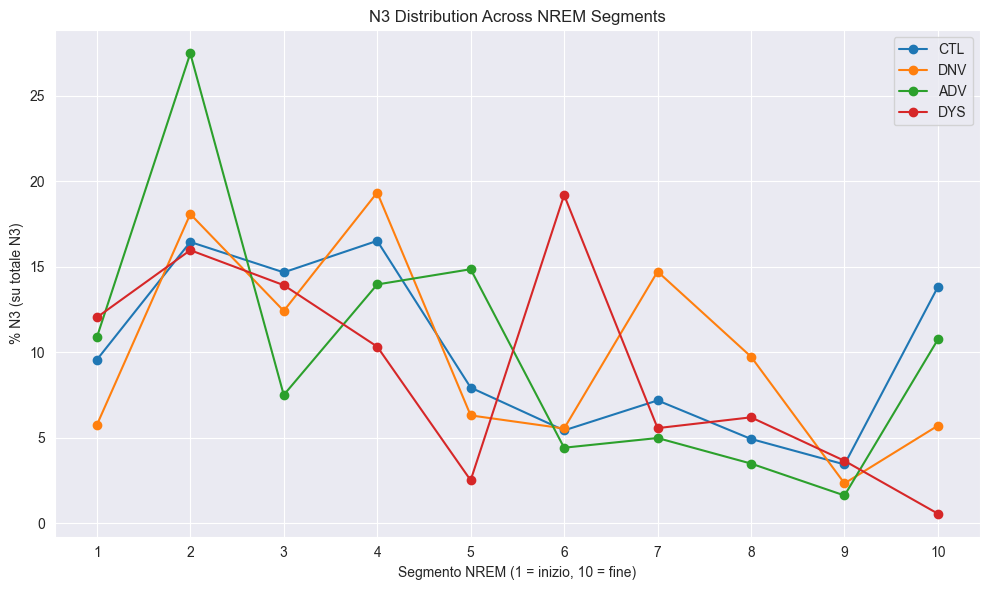

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inizializza la struttura per salvare i profili N3 per gruppo
group_n3_profiles = {group: [] for group in groups.keys()}
group_n3_profiles["Unknown"] = []  # In caso di soggetti non classificati

# Loop per ogni soggetto
for subject_id, stages in all_data:
    # Maschera per NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    # Se la sequenza NREM è troppo corta, si può eventualmente saltare
    if len(nrem_stages) < 10:
        continue

    # Divide in 10 segmenti uguali
    segment_length = len(nrem_stages) // 10
    n3_counts = []

    for i in range(10):
        start = i * segment_length
        # L’ultimo segmento prende tutto quello che resta
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_count = np.sum(segment == 3)
        n3_counts.append(n3_count)

    # Normalizza in percentuale sul totale N3 del soggetto
    total_n3 = sum(n3_counts)
    if total_n3 > 0:
        n3_profile = [count / total_n3 * 100 for count in n3_counts]
    else:
        n3_profile = [0] * 10

    # Salva nel gruppo corretto
    group = next((group_name for group_name, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles[group].append(n3_profile)
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_profiles.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long = pd.DataFrame(rows)


# Calcolo della media per ciascun gruppo
group_n3_avg_profiles = {}
for group, profiles in group_n3_profiles.items():
    if profiles:  # Se il gruppo ha almeno un soggetto
        mean_profile = np.mean(profiles, axis=0)
        group_n3_avg_profiles[group] = mean_profile

# Crea il DataFrame finale con righe = gruppi, colonne = segmenti
df_n3_distribution = pd.DataFrame(
    group_n3_avg_profiles,
    index=[f"Segment_{i+1}" for i in range(10)]
).T  # Transpose: gruppi su righe, segmenti su colonne

# Stampa il DataFrame
print("\nN3 Distribution Across NREM Segments:")
print(df_n3_distribution.round(2))

# Plot
plt.figure(figsize=(10, 6))
x = range(1, 11)

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles:
        plt.plot(x, group_n3_avg_profiles[group], marker='o', label=group)

plt.title("N3 Distribution Across NREM Segments")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3 (su totale N3)")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


▶ Average % of N3 (of total N3) per segment [WITHOUT AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       8.37      16.72      17.10      12.85       8.94       6.41   
DNV       8.16      15.97      13.26      18.92       6.28       7.36   
ADV      11.47      27.08      10.95       8.57      16.27       4.72   
DYS      11.10      16.63      13.71       9.93       4.65      17.38   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       7.20       4.85       4.78       12.79  
DNV      12.20       9.25       2.74        5.87  
ADV       5.72       2.90       2.22       10.10  
DYS       6.17       4.46       5.48        0.48  


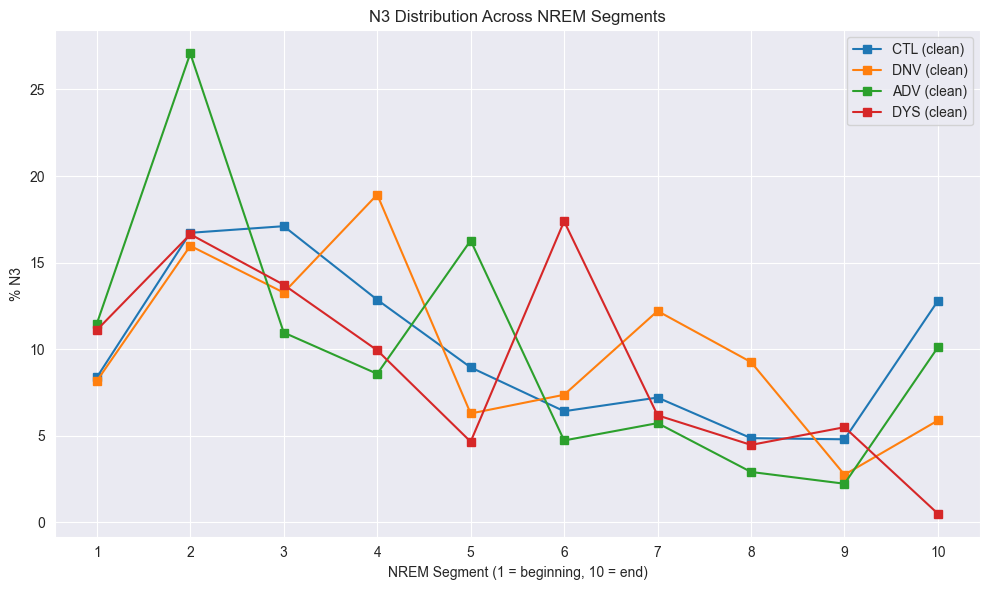

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- WITHOUT AROUSALS ---

# Initialize the structure to save N3 profiles for each group
group_n3_profiles_clean = {group: [] for group in groups.keys()}
group_n3_profiles_clean["Unknown"] = []  # For subjects not classified into any group

# Loop through each subject
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_mask = arousals != 1  # Mask out arousals
    clean_stages = stages[arousals_mask]

    # Mask for NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(clean_stages, [1, 2, 3])
    nrem_stages = clean_stages[nrem_mask]

    # Skip if the NREM sequence is too short
    if len(nrem_stages) < 10:
        continue

    # Divide into 10 equal segments
    segment_length = len(nrem_stages) // 10
    n3_counts = []  # List to store N3 counts for each segment

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_counts.append(np.sum(segment == 3))

    # Normalize the N3 counts as a percentage of the total N3 for the subject
    total_n3 = sum(n3_counts)
    n3_profile = [count / total_n3 * 100 if total_n3 > 0 else 0 for count in n3_counts]

    # Assign the profile to the correct group
    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles_clean[group].append(n3_profile)

# Prepare the data for the DataFrame
rows = []

# Reverse the groups to find subject → group
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Use a counter because group_n3_profiles only has profiles, not subject IDs
for group, profiles in group_n3_profiles_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # Create a unique ID for each subject
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_clean = pd.DataFrame(rows)

# Calculate the average for each group
group_n3_avg_profiles_clean = {
    group: np.mean(profiles, axis=0)
    for group, profiles in group_n3_profiles_clean.items()
    if profiles
}

# Create the DataFrame for the average N3 distribution
df_n3_distribution_clean = pd.DataFrame(
    group_n3_avg_profiles_clean,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

# Print the average N3 distribution for each group
print("\n▶ Average % of N3 (of total N3) per segment [WITHOUT AROUSALS]:")
print(df_n3_distribution_clean.round(2))

# Plot the N3 distribution
x = np.arange(1, 11)
plt.figure(figsize=(10, 6))

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles_clean:
        plt.plot(x, group_n3_avg_profiles_clean[group], marker='s', linestyle='-', label=f"{group} (clean)")

plt.title("N3 Distribution Across NREM Segments")
plt.xlabel("NREM Segment (1 = beginning, 10 = end)")
plt.ylabel("% N3")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [244]:
from scipy.stats import ttest_rel, wilcoxon, shapiro
import pandas as pd

# Segmenti che definiscono le fasi Early e Late del NREM
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

# Calcolo della media delle fasi Early e Late per ogni soggetto
df_long_clean["Early"] = df_long_clean[early_segments].mean(axis=1)
df_long_clean["Late"] = df_long_clean[late_segments].mean(axis=1)

# Lista per raccogliere i risultati
results = []

# Loop su ciascun gruppo
for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_clean[df_long_clean["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]

    # Calcolo della differenza paired (early - late)
    diff = early - late

    # Test di normalità sulle differenze
    p_shapiro_diff = shapiro(diff)[1]
    normal_diff = p_shapiro_diff > 0.05
    dist_label = f"Normal ({p_shapiro_diff:.3f})" if normal_diff else f"Non-normal ({p_shapiro_diff:.3f})"

    # Paired t-test o Wilcoxon signed-rank test a seconda della normalità
    if normal_diff:
        stat, pval = ttest_rel(early, late)
        test = "Paired t-test"
    else:
        stat, pval = wilcoxon(early, late)
        test = "Wilcoxon signed-rank"

    # Verifica se rifiutare l'ipotesi nulla (p < 0.05)
    reject_null = pval < 0.05

    # Salva i risultati
    results.append({
        "Group": group,
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Distribution (p-value)": dist_label,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.3f}",
        "Reject H₀": "Yes" if reject_null else "No",
    })

# Creazione del DataFrame dei risultati
df_early_late_stats = pd.DataFrame(results)

# Stampa i risultati
print("\n📊 Paired comparison of Early vs Late N3 distribution (per group):")
print(df_early_late_stats)



📊 Paired comparison of Early vs Late N3 distribution (per group):
  Group  Early Mean  Late Mean Distribution (p-value)           Test   Stat  \
0   CTL       15.56       5.61         Normal (0.469)  Paired t-test  3.142   
1   DNV       16.05       8.06         Normal (0.568)  Paired t-test  1.697   
2   ADV       15.54       3.61         Normal (0.912)  Paired t-test  4.013   
3   DYS       13.43       5.37         Normal (0.266)  Paired t-test  2.414   

  p-value Reject H₀  
0   0.020       Yes  
1   0.165        No  
2   0.005       Yes  
3   0.039       Yes  



▶ Average N3 minutes per segment [WITH AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       5.14       8.71       8.43       7.93       3.50       3.14   
DNV       6.50      13.90      10.80      12.10       7.80       6.30   
ADV       7.75      12.44       6.50       6.12       9.75       5.06   
DYS       9.20      12.25      11.20       7.45       2.05       7.55   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       3.43       2.71       1.29        6.57  
DNV       7.40       9.30       2.70        3.30  
ADV       4.25       3.19       1.94        7.56  
DYS       2.30       3.30       3.55        0.25  


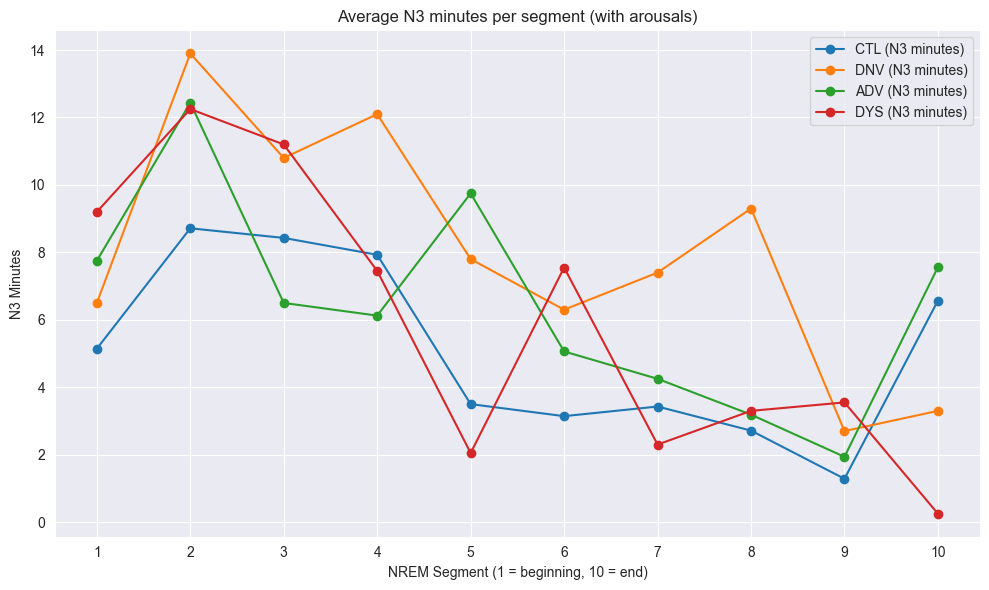

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- WITH AROUSALS INCLUDED (NO FILTERING) ---

# Initialize the structure to save N3 minutes profiles for each group
group_n3_minutes = {group: [] for group in groups.keys()}
group_n3_minutes["Unknown"] = []  # For subjects not classified into any group

# Loop through each subject (WITHOUT using arousals)
for subject_id, stages in all_data:
    
    # Mask for NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    # Skip if the NREM sequence is too short
    if len(nrem_stages) < 10:
        continue

    # Divide into 10 equal segments
    segment_length = len(nrem_stages) // 10
    n3_minutes = []  # List to store minutes in N3 for each segment

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        
        # Count the number of N3 in the segment
        n3_count = np.sum(segment == 3)
        
        # Convert to minutes (each epoch is 30 seconds)
        n3_minutes.append(n3_count / 2)

    # Store the minutes per segment
    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_minutes[group].append(n3_minutes)

# Prepare the data for the DataFrame
rows = []

# Reverse the groups to find subject → group
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Fill rows with subject profiles
for group, profiles in group_n3_minutes.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_min = pd.DataFrame(rows)

# Calculate the average for each group
group_n3_avg_minutes = {
    group: np.mean(minutes, axis=0)
    for group, minutes in group_n3_minutes.items()
    if minutes
}

# Create the DataFrame for the average N3 minutes
df_n3_minutes = pd.DataFrame(
    group_n3_avg_minutes,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

print("\n▶ Average N3 minutes per segment [WITH AROUSALS]:")
print(df_n3_minutes.round(2))

# Plot the N3 minutes
x = np.arange(1, 11)
plt.figure(figsize=(10, 6))

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_minutes:
        plt.plot(x, group_n3_avg_minutes[group], marker='o', linestyle='-', label=f"{group} (N3 minutes)")

plt.title("Average N3 minutes per segment (with arousals)")
plt.xlabel("NREM Segment (1 = beginning, 10 = end)")
plt.ylabel("N3 Minutes")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



▶ Average N3 minutes per segment [WITHOUT AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       4.50       8.43       9.79       6.71       3.29       3.29   
DNV       7.90      12.10      11.40      10.90       7.60       6.30   
ADV       7.75      12.00       6.88       5.44       9.56       4.94   
DYS       8.65      11.65      10.30       7.65       2.90       6.40   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       3.36       2.79       1.71        6.07  
DNV       6.30       8.60       3.20        3.30  
ADV       4.12       3.19       2.31        6.88  
DYS       3.30       2.25       4.40        0.20  


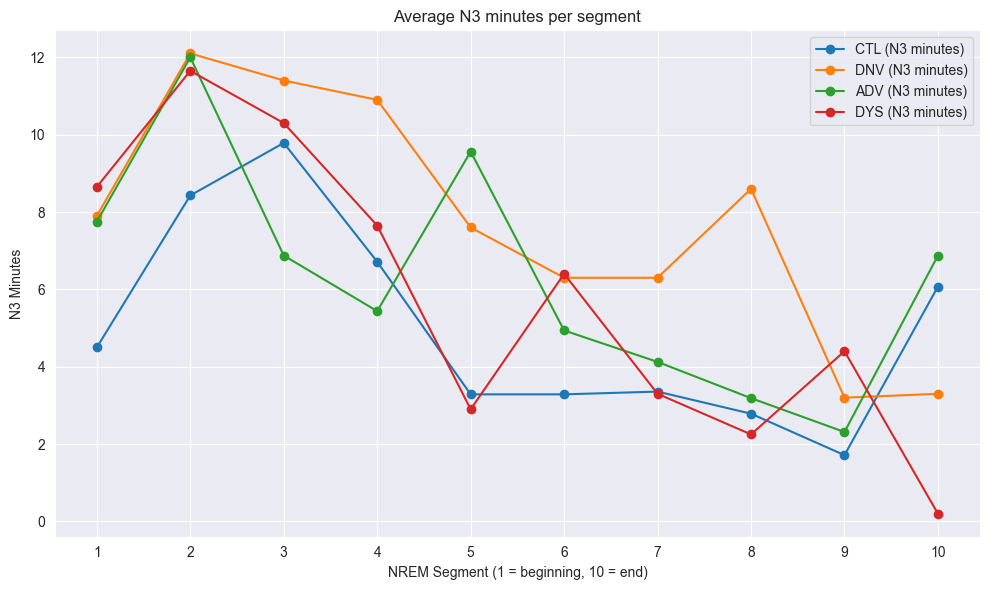

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- WITHOUT AROUSALS ---

# Initialize the structure to save N3 minutes profiles for each group
group_n3_minutes_clean = {group: [] for group in groups.keys()}
group_n3_minutes_clean["Unknown"] = []  # For subjects not classified into any group

# Loop through each subject
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_mask = arousals != 1  # Mask out arousals
    clean_stages = stages[arousals_mask]

    # Mask for NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(clean_stages, [1, 2, 3])
    nrem_stages = clean_stages[nrem_mask]

    # Skip if the NREM sequence is too short
    if len(nrem_stages) < 10:
        continue

    # Divide into 10 equal segments
    segment_length = len(nrem_stages) // 10
    n3_minutes = []  # List to store minutes in N3 for each segment

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        
        # Count the number of N3 in the segment
        n3_count = np.sum(segment == 3)
        
        # Add the number of minutes in N3 for each segment (each epoch is 30 seconds)
        n3_minutes.append(n3_count / 2)  # Divide by 2 to get the minutes

    # Store the average N3 minutes per segment
    n3_minutes_avg = [minute for minute in n3_minutes]

    # Determine the group of the subject
    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_minutes_clean[group].append(n3_minutes_avg)

# Prepare the data for the DataFrame
rows = []

# Reverse the groups to find subject → group
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Use a counter because group_n3_profiles only has profiles, not subject IDs
for group, profiles in group_n3_minutes_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # Create a unique ID for each subject
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_min = pd.DataFrame(rows)

# Calculate the average for each group
group_n3_avg_minutes_clean = {
    group: np.mean(minutes, axis=0)
    for group, minutes in group_n3_minutes_clean.items()
    if minutes
}

# Create the DataFrame for the average N3 minutes
df_n3_minutes_clean = pd.DataFrame(
    group_n3_avg_minutes_clean,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

print("\n▶ Average N3 minutes per segment [WITHOUT AROUSALS]:")
print(df_n3_minutes_clean.round(2))

# Plot the N3 minutes
x = np.arange(1, 11)
plt.figure(figsize=(10, 6))

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_minutes_clean:
        plt.plot(x, group_n3_avg_minutes_clean[group], marker='o', linestyle='-', label=f"{group} (N3 minutes)")

plt.title("Average N3 minutes per segment")
plt.xlabel("NREM Segment (1 = beginning, 10 = end)")
plt.ylabel("N3 Minutes")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [247]:
from scipy.stats import ttest_rel, wilcoxon, shapiro
import pandas as pd

# Segmenti che definiscono le fasi Early e Late del NREM
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

# Calcolo della media delle fasi Early e Late per ogni soggetto
df_long_min["Early"] = df_long_min[early_segments].mean(axis=1)
df_long_min["Late"] = df_long_min[late_segments].mean(axis=1)

# Lista per raccogliere i risultati
results = []

# Loop su ciascun gruppo
for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_min[df_long_min["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]

    # Calcolo della differenza paired (early - late)
    diff = early - late

    # Test di normalità sulle differenze
    p_shapiro_diff = shapiro(diff)[1]
    normal_diff = p_shapiro_diff > 0.05
    dist_label = f"Normal ({p_shapiro_diff:.3f})" if normal_diff else f"Non-normal ({p_shapiro_diff:.3f})"

    # Paired t-test o Wilcoxon signed-rank test a seconda della normalità
    if normal_diff:
        stat, pval = ttest_rel(early, late)
        test = "Paired t-test"
    else:
        stat, pval = wilcoxon(early, late)
        test = "Wilcoxon signed-rank"

    # Verifica se rifiutare l'ipotesi nulla (p < 0.05)
    reject_null = pval < 0.05

    # Salva i risultati
    results.append({
        "Group": group,
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Distribution (p-value)": dist_label,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.3f}",  # P-value in formato decimale (es. 0.163)
        "Reject H₀": "Yes" if reject_null else "No",
    })

# Creazione del DataFrame dei risultati
df_early_late_stats = pd.DataFrame(results)

# Stampa i risultati
print("\n📊 Minute:")
print(df_early_late_stats)



📊 Paired comparison of Early vs Late N3 distribution (per group):
  Group  Early Mean  Late Mean Distribution (p-value)                  Test  \
0   CTL        8.31       2.62         Normal (0.431)         Paired t-test   
1   DNV       11.47       6.03         Normal (0.816)         Paired t-test   
2   ADV        8.10       3.21         Normal (0.314)         Paired t-test   
3   DYS        9.87       3.32     Non-normal (0.044)  Wilcoxon signed-rank   

    Stat p-value Reject H₀  
0  2.880   0.028       Yes  
1  2.569   0.062        No  
2  3.067   0.018       Yes  
3  3.000   0.036       Yes  



▶ Average % N3 (of total NREM) per segment [WITH AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL      19.50      33.54      29.47      33.40      16.32      11.49   
DNV      23.19      52.73      40.61      47.93      26.61      22.48   
ADV      28.19      48.33      25.47      23.25      34.32      18.88   
DYS      28.98      40.79      39.37      26.41       6.41      29.86   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL      12.48       9.93       6.19       24.59  
DNV      27.02      33.69       9.88       11.52  
ADV      16.78      10.97       6.75       28.43  
DYS      10.45      12.13      13.38        0.89  


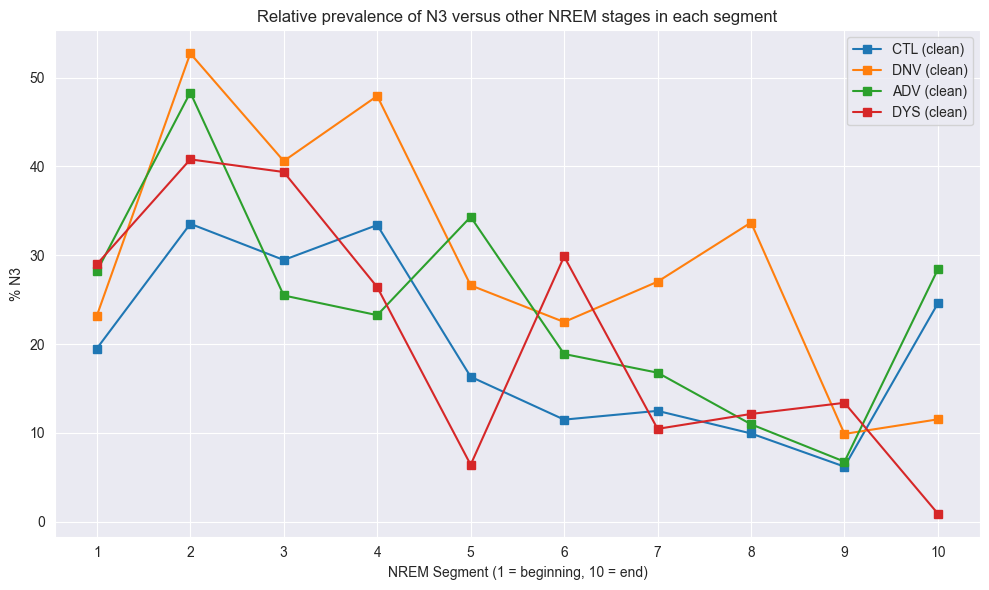

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'groups' and 'all_data' are already defined and contain the necessary data.

# Initialize the dictionary to store the N3 profiles for each group
group_n3_profiles_clean = {group: [] for group in groups.keys()}
group_n3_profiles_clean["Unknown"] = []

# Iterate over each subject and their EEG data (WITHOUT arousals filtering)
for subject_id, stages in all_data:
    
    # Select only the NREM stages (N1, N2, N3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    # Exclude this subject if the NREM sleep duration is too short
    if len(nrem_stages) < 10:
        continue

    # Split NREM sleep into 10 segments (Here begins the modified section)
    segment_length = len(nrem_stages) // 10
    n3_counts = []
    nrem_counts = []

    # Count the amount of N3 and total NREM in each segment
    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_counts.append(np.sum(segment == 3))  # Count the number of N3
        nrem_counts.append(len(segment))  # Count the total number of NREM (N1 + N2 + N3)

    # Calculate the percentage of N3 in each segment relative to the total NREM (N1 + N2 + N3)
    n3_profile = [n3 / total_nrem * 100 if total_nrem > 0 else 0 for n3, total_nrem in zip(n3_counts, nrem_counts)]

    # Assign the group of the subject
    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles_clean[group].append(n3_profile)

# Create a DataFrame with the N3 profiles of all subjects
rows = []

# Reverse 'groups' to obtain a mapping from subject -> group
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Add rows to the DataFrame with the profiles
for group, profiles in group_n3_profiles_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # Create a unique ID for each subject
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_norm_clean = pd.DataFrame(rows)

# Calculate the average N3 profiles for each group
group_n3_avg_profiles_clean = {
    group: np.mean(profiles, axis=0)
    for group, profiles in group_n3_profiles_clean.items()
    if profiles  # Only if the group has at least one profile
}

# Create a DataFrame with the average N3 distribution for each group
df_n3_distribution_clean = pd.DataFrame(
    group_n3_avg_profiles_clean,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

# Print the results
print("\n▶ Average % N3 (of total NREM) per segment [WITH AROUSALS]:")
print(df_n3_distribution_clean.round(2))

# Plot the average N3 profiles
x = np.arange(1, 11)  # x-axis: Segments from 1 to 10
plt.figure(figsize=(10, 6))

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles_clean:
        plt.plot(x, group_n3_avg_profiles_clean[group], marker='s', linestyle='-', label=f"{group} (clean)")

plt.title("Relative prevalence of N3 versus other NREM stages in each segment")
plt.xlabel("NREM Segment (1 = beginning, 10 = end)")
plt.ylabel("% N3")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



▶ Average % N3 (of total NREM) per segment [WITHOUT AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL      20.73      41.14      43.67      31.52      19.73      14.97   
DNV      31.99      50.83      47.63      50.69      28.76      25.57   
ADV      31.86      51.55      28.98      22.21      37.05      19.23   
DYS      32.76      45.76      43.01      30.49      11.46      33.69   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL      13.41      12.21       9.80       26.71  
DNV      27.46      34.56      12.87       12.09  
ADV      17.91      11.35       9.00       30.02  
DYS      15.37      11.19      18.65        1.01  


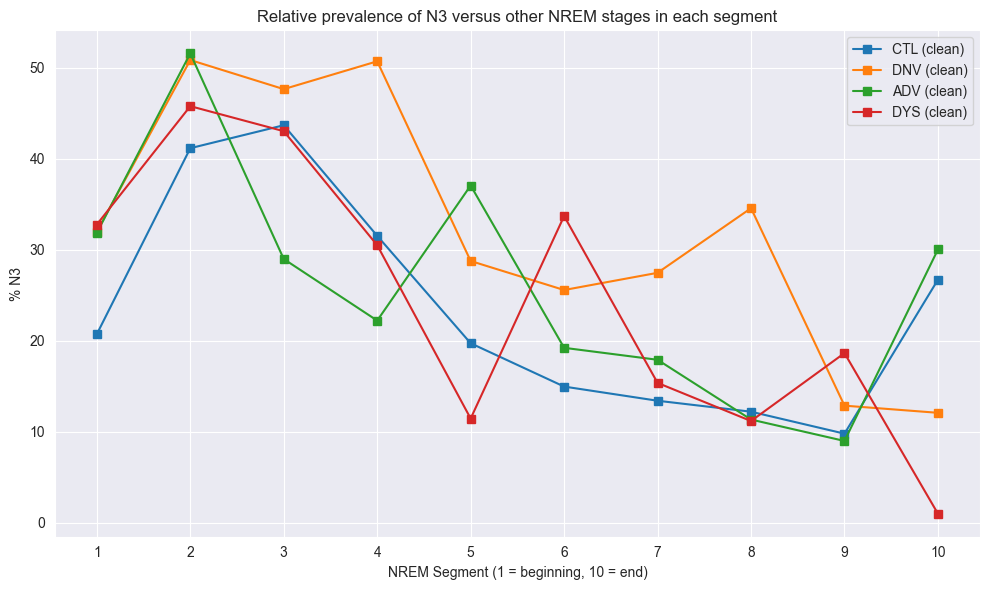

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'groups' and 'all_data' are already defined and contain the necessary data.
# Perform the analysis WITHOUT AROUSALS:

# Initialize the dictionary to store the N3 profiles for each group
group_n3_profiles_clean = {group: [] for group in groups.keys()}
group_n3_profiles_clean["Unknown"] = []

# Iterate over each subject and their EEG data and arousals
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_mask = arousals != 1  # Exclude arousals (where arousals == 1)
    clean_stages = stages[arousals_mask]  # Remove arousals

    # Select only the NREM stages (N1, N2, N3)
    nrem_mask = np.isin(clean_stages, [1, 2, 3])
    nrem_stages = clean_stages[nrem_mask]

    # Exclude this subject if the NREM sleep duration is too short
    if len(nrem_stages) < 10:
        continue

    # Split NREM sleep into 10 segments
    segment_length = len(nrem_stages) // 10
    n3_counts = []
    nrem_counts = []

    # Count the amount of N3 and total NREM in each segment
    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_counts.append(np.sum(segment == 3))  # Count the number of N3
        nrem_counts.append(len(segment))  # Count the total number of NREM (N1 + N2 + N3)

    # Calculate the percentage of N3 in each segment relative to the total NREM (N1 + N2 + N3)
    n3_profile = [n3 / total_nrem * 100 if total_nrem > 0 else 0 for n3, total_nrem in zip(n3_counts, nrem_counts)]

    # Assign the group of the subject
    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles_clean[group].append(n3_profile)

# Create a DataFrame with the N3 profiles of all subjects
rows = []

# Reverse 'groups' to obtain a mapping from subject -> group
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Add rows to the DataFrame with the profiles
for group, profiles in group_n3_profiles_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # Create a unique ID for each subject
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_norm_clean = pd.DataFrame(rows)

# Calculate the average N3 profiles for each group
group_n3_avg_profiles_clean = {
    group: np.mean(profiles, axis=0)
    for group, profiles in group_n3_profiles_clean.items()
    if profiles  # Only if the group has at least one profile
}

# Create a DataFrame with the average N3 distribution for each group
df_n3_distribution_clean = pd.DataFrame(
    group_n3_avg_profiles_clean,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

# Print the results
print("\n▶ Average % N3 (of total NREM) per segment [WITHOUT AROUSALS]:")
print(df_n3_distribution_clean.round(2))

# Plot the average N3 profiles
x = np.arange(1, 11)  # x-axis: Segments from 1 to 10
plt.figure(figsize=(10, 6))

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles_clean:
        plt.plot(x, group_n3_avg_profiles_clean[group], marker='s', linestyle='-', label=f"{group} (clean)")

plt.title("Relative prevalence of N3 versus other NREM stages in each segment")
plt.xlabel("NREM Segment (1 = beginning, 10 = end)")
plt.ylabel("% N3")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [250]:
from scipy.stats import ttest_rel, wilcoxon, shapiro
import pandas as pd

# Segmenti che definiscono le fasi Early e Late del NREM
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

# Calcolo della media delle fasi Early e Late per ogni soggetto
df_long_norm_clean["Early"] = df_long_norm_clean[early_segments].mean(axis=1)
df_long_norm_clean["Late"] = df_long_norm_clean[late_segments].mean(axis=1)

# Lista per raccogliere i risultati
results = []

# Loop su ciascun gruppo
for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_norm_clean[df_long_norm_clean["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]

    # Calcolo delle differenze paired
    diff = early - late

    # Test di normalità sulle differenze
    p_shapiro_diff = shapiro(diff)[1]
    normal_diff = p_shapiro_diff > 0.05
    dist_label = f"Normal ({p_shapiro_diff:.3f})" if normal_diff else f"Non-normal ({p_shapiro_diff:.3f})"

    # Paired t-test o Wilcoxon signed-rank test a seconda della normalità
    if normal_diff:
        stat, pval = ttest_rel(early, late)
        test = "Paired t-test"
    else:
        stat, pval = wilcoxon(early, late)
        test = "Wilcoxon signed-rank"

    # Verifica se rifiutare l'ipotesi nulla (p < 0.05)
    reject_null = pval < 0.05

    # Salva i risultati
    results.append({
        "Group": group,
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Distribution (p-value)": dist_label,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.3f}",
        "Reject H₀": "Yes" if reject_null else "No",
    })

# Creazione del DataFrame dei risultati
df_early_late_stats = pd.DataFrame(results)

# Stampa
print("\n📊 Paired comparison of Early vs Late N3 distribution (per group):")
print(df_early_late_stats)



📊 Paired comparison of Early vs Late N3 distribution (per group):
  Group  Early Mean  Late Mean Distribution (p-value)           Test   Stat  \
0   CTL       38.78      11.81         Normal (0.289)  Paired t-test  2.790   
1   DNV       49.71      24.96         Normal (0.488)  Paired t-test  2.144   
2   ADV       34.25      12.75         Normal (0.317)  Paired t-test  3.319   
3   DYS       39.75      15.07         Normal (0.124)  Paired t-test  2.763   

  p-value Reject H₀  
0   0.032       Yes  
1   0.099        No  
2   0.013       Yes  
3   0.022       Yes  


.MAT OLD SCORING
--------------------------------
-----------------------------------


In [101]:
import os
import numpy as np

folder_path = r"D:\TESI\sleep_stages_09_12\matlab_scoring\Labels"

groups = {
    "CTL": ["PD009", "PD010", "PD020", "PD022", "PD025", "PD033", "PD043"],
    "DNV": ["PD005", "PD013", "PD027", "PD031", "PD041"],
    "ADV": ["PD002", "PD003", "PD007", "PD008", "PD021", "PD028", "PD036", "PD042"],
    "DYS": ["PD012", "PD014", "PD016", "PD017", "PD029", "PD030", "PD035", "PD038", "PD044", "PD045"],
}

subject_to_group = {subj: group for group, subjects in groups.items() for subj in subjects}

all_data = []

for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        # Estrai l'ID del soggetto rimuovendo 'EEG' se presente
        subject_part = filename.replace('.npy', '')
        subject_id = subject_part

        if subject_id in subject_to_group:
            group = subject_to_group[subject_id]
            full_path = os.path.join(folder_path, filename)
            scoring = np.load(full_path)
            all_data.append((subject_id, group, scoring))
            print(f"✅ {subject_id} ({group}) - scoring: {len(scoring)}")
        else:
            print(f"⚠️ {subject_id} non è in nessun gruppo definito.")

print(f"\nTotale soggetti caricati: {len(all_data)}")


✅ PD002 (ADV) - scoring: 868
✅ PD003 (ADV) - scoring: 979
✅ PD007 (ADV) - scoring: 986
✅ PD008 (ADV) - scoring: 911
✅ PD021 (ADV) - scoring: 782
✅ PD028 (ADV) - scoring: 855
⚠️ PD032 non è in nessun gruppo definito.
✅ PD036 (ADV) - scoring: 1025
✅ PD042 (ADV) - scoring: 997
✅ PD009 (CTL) - scoring: 993
✅ PD010 (CTL) - scoring: 837
✅ PD020 (CTL) - scoring: 892
✅ PD022 (CTL) - scoring: 893
✅ PD033 (CTL) - scoring: 895
✅ PD043 (CTL) - scoring: 910
✅ PD005 (DNV) - scoring: 882
✅ PD013 (DNV) - scoring: 936
✅ PD027 (DNV) - scoring: 922
✅ PD031 (DNV) - scoring: 876
✅ PD041 (DNV) - scoring: 886
✅ PD012 (DYS) - scoring: 869
✅ PD014 (DYS) - scoring: 966
✅ PD016 (DYS) - scoring: 860
✅ PD017 (DYS) - scoring: 1053
✅ PD030 (DYS) - scoring: 831
✅ PD035 (DYS) - scoring: 826
✅ PD038 (DYS) - scoring: 949
✅ PD044 (DYS) - scoring: 1030
✅ PD045 (DYS) - scoring: 759

Totale soggetti caricati: 28


In [102]:
import pandas as pd
import numpy as np

# Definizione delle fasi
sleep_values = [1, 2, 3, 4]  # N1, N2, N3, REM
scoring_data = []

for subject_id, group, scoring in all_data:
    scoring = scoring.astype(int)
    total_epochs = len(scoring)
    total_minutes = total_epochs * 0.5

    tst_epochs = np.isin(scoring, sleep_values).sum()
    tst_minutes = tst_epochs * 0.5

    se = tst_minutes / total_minutes * 100

    # Sleep Latency
    sleep_found = np.isin(scoring, sleep_values)
    if np.any(sleep_found):
        sl_epochs = np.argmax(sleep_found)
        sl_minutes = sl_epochs * 0.5
    else:
        sl_minutes = np.nan

    # SWS (N3)
    sws_minutes = (scoring == 3).sum() * 0.5

    # WASO
    if np.any(sleep_found):
        sleep_onset_idx = np.argmax(sleep_found)
        waso_epochs = np.sum(scoring[sleep_onset_idx+1:] == 0)
        waso_minutes = waso_epochs * 0.5
    else:
        waso_minutes = np.nan

    # WAKE (percentuale di epoche in cui si è svegli)
    wake_epochs = (scoring == 0).sum()  # Epoche di sveglio (0)
    wake_percent = wake_epochs / total_epochs * 100

    # REM (percentuale di epoche in fase REM)
    rem_epochs = (scoring == 4).sum()  # Epoche in REM (5)
    rem_percent = rem_epochs / total_epochs * 100

    # Percentuale N1, N2, N3
    n1_percent = (scoring == 1).sum() / total_epochs * 100
    n2_percent = (scoring == 2).sum() / total_epochs * 100
    n3_percent = (scoring == 3).sum() / total_epochs * 100

    scoring_data.append({
        "Subject": subject_id,
        "Group": group,        
        "TST (min)": tst_minutes,
        "SE (%)": se,
        "SL (min)": sl_minutes,
        "WASO (min)": waso_minutes,
        "SWS (min)": sws_minutes,        
        "WAKE (%)": wake_percent,
        "N1 (%)": n1_percent,
        "N2 (%)": n2_percent,
        "N3 (%)": n3_percent,
        "REM (%)": rem_percent  # REM dopo N3
    })

# Creazione del DataFrame
df = pd.DataFrame(scoring_data)

# Seleziona solo le colonne numeriche, ordinate correttamente
metrics_cols = [
    "TST (min)", "SE (%)", "SL (min)", "WASO (min)", 
    "SWS (min)", "WAKE (%)", "N1 (%)", "N2 (%)", "N3 (%)", "REM (%)"
]

# Calcolo media e std per gruppo
group_stats = df.groupby("Group")[metrics_cols].agg(['mean', 'std'])

# Trasposizione per avere gruppi sulle colonne
group_stats_T = group_stats.T

# Ordina le colonne come richiesto
ordered_groups = ["CTL", "DNV", "ADV", "DYS"]
group_stats_T = group_stats_T[ordered_groups]

# Visualizzazione finale (con valori arrotondati a 2 decimali)
group_stats_T.round(2)


Group               CTL     DNV     ADV     DYS
TST (min)  mean  297.50  357.70  313.25  275.83
           std    61.61   17.31   47.40   97.79
SE (%)     mean   65.94   79.55   67.99   60.05
           std    13.72    5.25   10.61   17.01
SL (min)   mean   35.75   13.70   30.38   16.56
           std    38.45    7.03   26.08   16.34
WASO (min) mean  118.42   78.80  119.06  160.00
           std    67.53   30.04   58.97   66.49
SWS (min)  mean   54.83   77.60   57.50   50.39
           std    12.68   49.90   44.25   34.03
WAKE (%)   mean   34.06   20.45   32.01   39.95
           std    13.72    5.25   10.61   17.01
N1 (%)     mean    7.49   12.96    7.29    7.76
           std     1.61    9.32    3.64    3.08
N2 (%)     mean   36.08   36.08   38.51   36.49
           std    10.31    7.67   15.18   13.81
N3 (%)     mean   12.21   17.25   12.91   10.86
           std     3.00   11.00   10.45    6.42
REM (%)    mean   10.16   13.25    9.28    4.94
           std     6.50    5.75    5.12    5.50

In [103]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, bartlett, fligner, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Funzione per calcolare il riassunto statistico
def compute_statistical_summary(df, metrics_cols):
    summary = []

    for feature in metrics_cols:
        values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

        # ✅ Test di normalità con Shapiro-Wilk
        group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan  # evita errori con gruppi piccolissimi
                           for g, data in zip(ordered_groups, values_by_group)}
        all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

        # Colonna 'Distribution (p-value)'
        if all_normal:
            distribution = f"Normal (p={round(min(group_normality.values()), 3)})"
        else:
            distribution = f"Not Normal (p={round(min(group_normality.values()), 3)})"

        # Test di omogeneità della varianza
        if all_normal:
            levene_p = levene(*values_by_group)[1]
            bartlett_p = bartlett(*values_by_group)[1]
            var_test = "Homogeneous" if levene_p > 0.05 else "Heterogeneous"
            var_p = levene_p if levene_p > 0.05 else bartlett_p
        else:
            var_p = fligner(*values_by_group)[1]
            var_test = "Homogeneous" if var_p > 0.05 else "Heterogeneous"

        # Colonna 'Variance (p-value)'
        variance = f"{var_test} (p={round(var_p, 3)})"

        # Test statistico
        if all_normal and var_p > 0.05:
            stat, p = f_oneway(*values_by_group)
            test_used = "One-Way ANOVA"
        elif all_normal:
            stat, p = f_oneway(*values_by_group)
            test_used = "Welch's ANOVA"
        else:
            stat, p = kruskal(*values_by_group)
            test_used = "Kruskal-Wallis"

        # Calcolo media e std per ogni gruppo
        means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
        stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

        row = {
            "Feature": feature,
            "Distribution (p-value)": distribution,
            "Variance (p-value)": variance,
            "Test": test_used,
            "Stat": round(stat, 3),
            "p-value": f"{p:.2e}"
        }

        # Aggiungi media e std per ogni gruppo
        for g in ordered_groups:
            row[f"{g} Mean"] = means[g]
            row[f"{g} Std"] = stds[g]

        summary.append(row)

    return pd.DataFrame(summary)

# Chiamata alla funzione
stats_summary_df = compute_statistical_summary(df, metrics_cols)

# Mostra il risultato
pd.set_option('display.max_columns', None)
print(stats_summary_df)


      Feature Distribution (p-value)     Variance (p-value)            Test  \
0   TST (min)        Normal (p=0.35)  Homogeneous (p=0.065)   One-Way ANOVA   
1      SE (%)       Normal (p=0.179)  Homogeneous (p=0.115)   One-Way ANOVA   
2    SL (min)       Normal (p=0.104)  Homogeneous (p=0.225)   One-Way ANOVA   
3  WASO (min)       Normal (p=0.138)  Homogeneous (p=0.366)   One-Way ANOVA   
4   SWS (min)   Not Normal (p=0.031)  Homogeneous (p=0.502)  Kruskal-Wallis   
5    WAKE (%)       Normal (p=0.179)  Homogeneous (p=0.115)   One-Way ANOVA   
6      N1 (%)       Normal (p=0.167)  Homogeneous (p=0.135)   One-Way ANOVA   
7      N2 (%)   Not Normal (p=0.007)  Homogeneous (p=0.574)  Kruskal-Wallis   
8      N3 (%)       Normal (p=0.098)  Homogeneous (p=0.264)   One-Way ANOVA   
9     REM (%)   Not Normal (p=0.024)  Homogeneous (p=0.909)  Kruskal-Wallis   

    Stat   p-value  CTL Mean  CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  \
0  1.595  2.17e-01    297.50    61.61    357.70    


Distribuzione media % di N3 (su totale N3) per segmento, per gruppo:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       7.81      24.46      18.09      12.76      10.27       5.81   
DNV       8.58      20.57      24.08      14.84       7.75       6.44   
ADV      20.47      17.63       5.18       9.98      12.36       7.41   
DYS      17.77      17.12      12.22      13.75       7.98      14.77   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       0.67       4.36       6.70        9.07  
DNV       1.95       8.48       2.32        5.00  
ADV       3.95       0.00       5.72        4.80  
DYS       3.64       7.15       3.59        2.01  


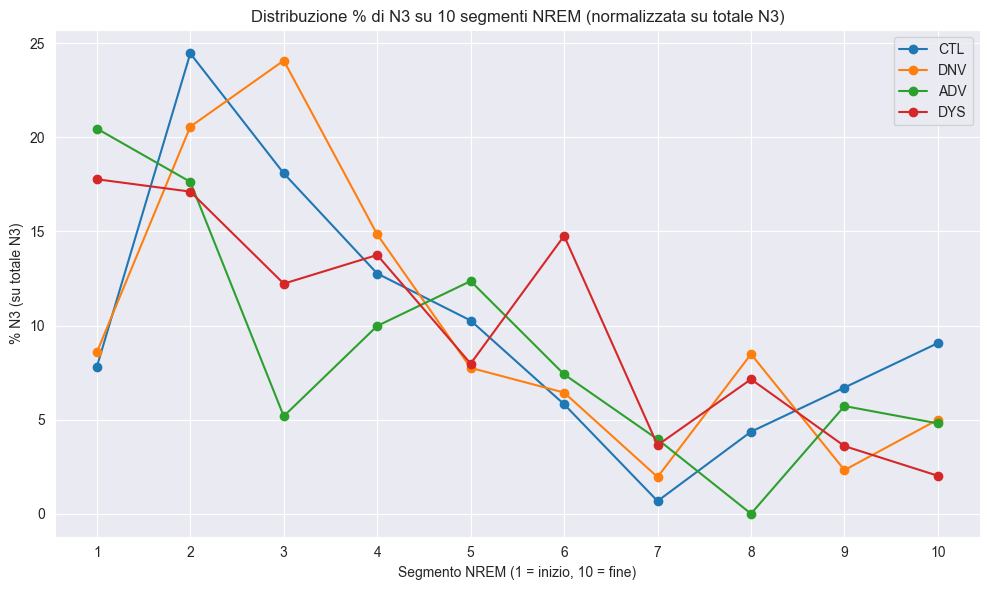

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inizializza la struttura per salvare i profili N3 per gruppo
group_n3_profiles = {group: [] for group in groups.keys()}
group_n3_profiles["Unknown"] = []  # In caso di soggetti non classificati

# Loop per ogni soggetto
for subject_id, group, stages in all_data:

    # Maschera per NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    # Se la sequenza NREM è troppo corta, si può eventualmente saltare
    if len(nrem_stages) < 10:
        continue

    # Divide in 10 segmenti uguali
    segment_length = len(nrem_stages) // 10
    n3_counts = []

    for i in range(10):
        start = i * segment_length
        # L’ultimo segmento prende tutto quello che resta
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_count = np.sum(segment == 3)
        n3_counts.append(n3_count)

    # Normalizza in percentuale sul totale N3 del soggetto
    total_n3 = sum(n3_counts)
    if total_n3 > 0:
        n3_profile = [count / total_n3 * 100 for count in n3_counts]
    else:
        n3_profile = [0] * 10

    # Salva nel gruppo corretto
    group = next((group_name for group_name, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles[group].append(n3_profile)
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_profiles.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long = pd.DataFrame(rows)


# Calcolo della media per ciascun gruppo
group_n3_avg_profiles = {}
for group, profiles in group_n3_profiles.items():
    if profiles:  # Se il gruppo ha almeno un soggetto
        mean_profile = np.mean(profiles, axis=0)
        group_n3_avg_profiles[group] = mean_profile

# Crea il DataFrame finale con righe = gruppi, colonne = segmenti
df_n3_distribution = pd.DataFrame(
    group_n3_avg_profiles,
    index=[f"Segment_{i+1}" for i in range(10)]
).T  # Transpose: gruppi su righe, segmenti su colonne

# Stampa il DataFrame
print("\nDistribuzione media % di N3 (su totale N3) per segmento, per gruppo:")
print(df_n3_distribution.round(2))

# Plot
plt.figure(figsize=(10, 6))
x = range(1, 11)

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles:
        plt.plot(x, group_n3_avg_profiles[group], marker='o', label=group)

plt.title("Distribuzione % di N3 su 10 segmenti NREM (normalizzata su totale N3)")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3 (su totale N3)")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


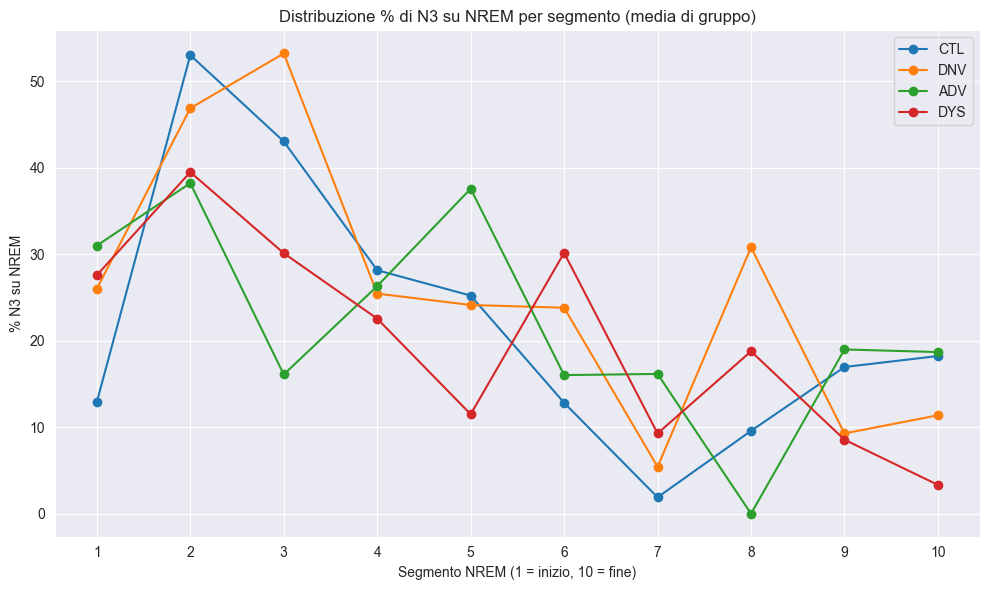


Percentuale media di N3 su NREM per segmento e per gruppo:

     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL      12.91      53.00      43.02      28.14      25.21      12.82   
DNV      26.01      46.85      53.19      25.44      24.12      23.81   
ADV      30.98      38.20      16.09      26.30      37.55      16.02   
DYS      27.57      39.47      30.11      22.54      11.50      30.14   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       1.89       9.57      16.95       18.22  
DNV       5.42      30.78       9.28       11.38  
ADV      16.15       0.00      18.98       18.68  
DYS       9.27      18.77       8.55        3.33  


In [105]:
import matplotlib.pyplot as plt

# Inizializza il dizionario per salvare i profili normalizzati N3/NREM
group_n3_norm_profiles = {group: [] for group in groups.keys()}
group_n3_norm_profiles["Unknown"] = []

# Calcolo per ogni soggetto
for subject_id, group, stages in all_data:
    # Maschera per NREM (1, 2, 3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    if len(nrem_stages) < 10:
        continue

    segment_length = len(nrem_stages) // 10
    segment_n3_ratios = []

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]

        n3_count = np.sum(segment == 3)
        nrem_count = len(segment)
        ratio = (n3_count / nrem_count * 100) if nrem_count > 0 else 0
        segment_n3_ratios.append(ratio)

    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_norm_profiles[group].append(segment_n3_ratios)
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_norm_profiles.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_norm = pd.DataFrame(rows)

# Calcola la media per gruppo
group_n3_segment_avg = {}
for group, profiles in group_n3_norm_profiles.items():
    if profiles:
        group_n3_segment_avg[group] = np.mean(profiles, axis=0)

# Plot
plt.figure(figsize=(10, 6))
x = range(1, 11)

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_segment_avg:
        plt.plot(x, group_n3_segment_avg[group], marker='o', label=group)

plt.title("Distribuzione % di N3 su NREM per segmento (media di gruppo)")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3 su NREM")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Creazione del DataFrame con i dati medi per gruppo
df_n3_segment = pd.DataFrame(group_n3_segment_avg, index=[f"Segment_{i+1}" for i in range(10)])

# Trasponi per avere i gruppi sulle righe (opzionale, ma più leggibile)
df_n3_segment = df_n3_segment.T

# Mostra il DataFrame arrotondato a 2 decimali
print("\nPercentuale media di N3 su NREM per segmento e per gruppo:\n")
print(df_n3_segment.round(2))




▶ Average N3 minutes per segment [WITH AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       3.42      12.83      11.75       6.58       5.25       2.58   
DNV       7.80      13.80      15.30       7.80       7.40       7.50   
ADV       8.62       9.88       4.12       6.69       9.94       4.44   
DYS       7.94      10.50       8.33       5.17       3.44       7.50   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       0.42       2.83       3.83        5.33  
DNV       1.60       9.70       3.00        3.70  
ADV       3.88       0.00       4.69        5.25  
DYS       1.72       3.33       1.61        0.83  


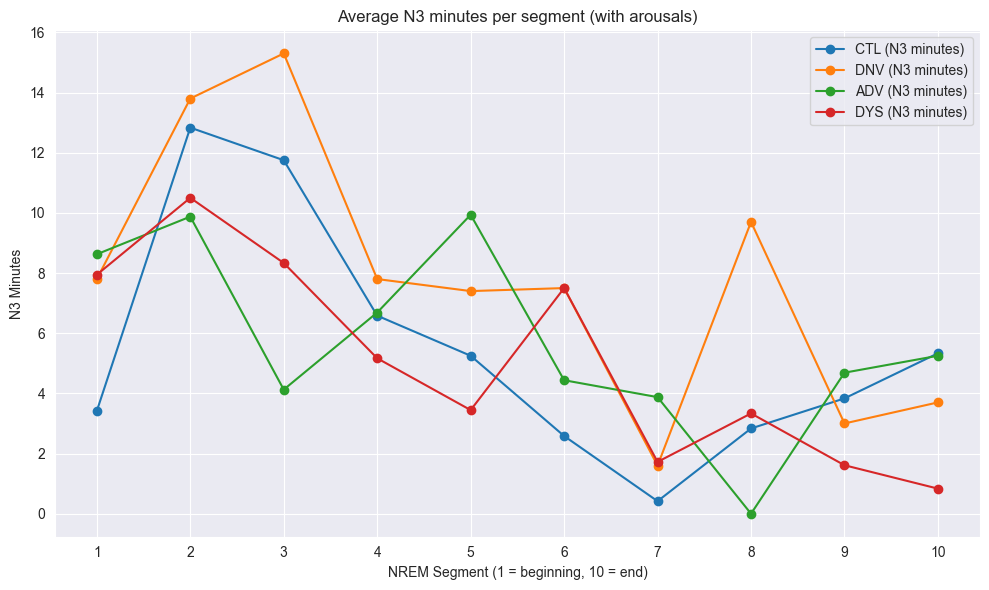

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- WITH AROUSALS INCLUDED (NO FILTERING) ---

# Initialize the structure to save N3 minutes profiles for each group
group_n3_minutes = {group: [] for group in groups.keys()}
group_n3_minutes["Unknown"] = []  # For subjects not classified into any group

# Loop through each subject (WITHOUT using arousals)
for subject_id, group, stages in all_data:
    
    # Mask for NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    # Skip if the NREM sequence is too short
    if len(nrem_stages) < 10:
        continue

    # Divide into 10 equal segments
    segment_length = len(nrem_stages) // 10
    n3_minutes = []  # List to store minutes in N3 for each segment

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        
        # Count the number of N3 in the segment
        n3_count = np.sum(segment == 3)
        
        # Convert to minutes (each epoch is 30 seconds)
        n3_minutes.append(n3_count / 2)

    # Store the minutes per segment
    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_minutes[group].append(n3_minutes)

# Prepare the data for the DataFrame
rows = []

# Reverse the groups to find subject → group
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Fill rows with subject profiles
for group, profiles in group_n3_minutes.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_min = pd.DataFrame(rows)

# Calculate the average for each group
group_n3_avg_minutes = {
    group: np.mean(minutes, axis=0)
    for group, minutes in group_n3_minutes.items()
    if minutes
}

# Create the DataFrame for the average N3 minutes
df_n3_minutes = pd.DataFrame(
    group_n3_avg_minutes,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

print("\n▶ Average N3 minutes per segment [WITH AROUSALS]:")
print(df_n3_minutes.round(2))

# Plot the N3 minutes
x = np.arange(1, 11)
plt.figure(figsize=(10, 6))

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_minutes:
        plt.plot(x, group_n3_avg_minutes[group], marker='o', linestyle='-', label=f"{group} (N3 minutes)")

plt.title("Average N3 minutes per segment (with arousals)")
plt.xlabel("NREM Segment (1 = beginning, 10 = end)")
plt.ylabel("N3 Minutes")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
